In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ama_tlbx.analysis import FeatureGroup, suggest_groups_from_correlation
from ama_tlbx.data import LECol, LifeExpectancyDataset
from ama_tlbx.plotting import (
    plot_group_compression,
    plot_group_loadings,
    plot_group_variance_summary,
)

np.random.seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["figure.labelsize"] = 11
plt.rcParams["figure.titleweight"] = "bold"


ImportError: cannot import name 'plot_group_biplot' from 'ama_tlbx.plotting.pca_dim_reduction_plots' (/Users/jd/Desktop/repos/ama_ws25/ama_tlbx/ama_tlbx/plotting/pca_dim_reduction_plots.py)

In [ ]:
le_ds = LifeExpectancyDataset.from_csv(aggregate_by_country=False)


# PCA-Based Dimensionality Reduction

Group highly correlated features and reduce each group to principal components, preserving interpretability and reducing multicollinearity.

[
    FeatureGroup(
        name='Group_1',
        features=[
            'infant_deaths',
            'under_five_deaths',
        ],
    ),
    FeatureGroup(
        name='Group_9',
        features=[
            'thinness_1_19_years',
            'thinness_5_9_years',
        ],
    ),
    FeatureGroup(
        name='Group_11',
        features=[
            'percentage_expenditure',
            'gdp',
        ],
    ),
]


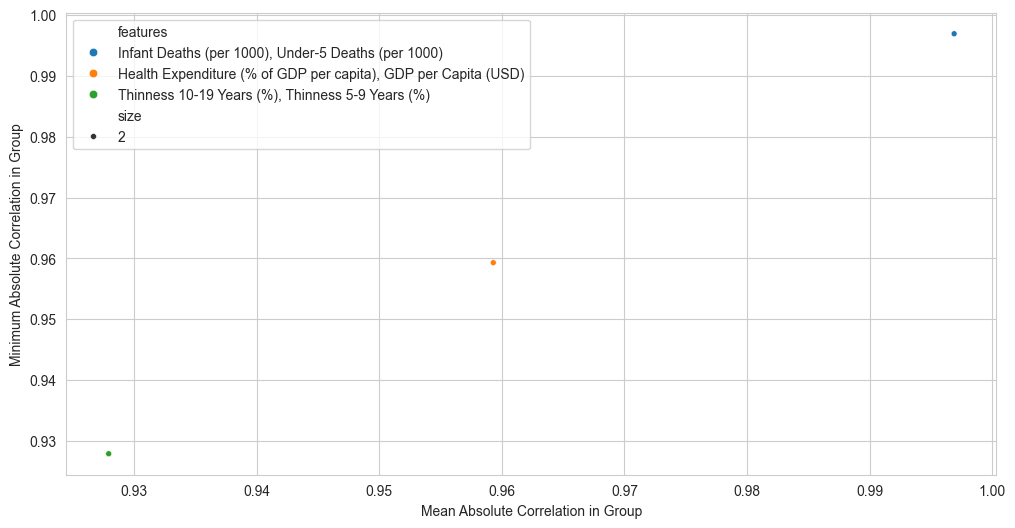

In [ ]:
from devtools import pprint

corr_mat = le_ds.make_correlation_analyzer(
    include_target=False
).get_correlation_matrix()
tresh = 0.8
suggested_groups, summary_df = suggest_groups_from_correlation(
    corr_mat, threshold=tresh, return_summary=True
)
pprint(suggested_groups)
summary_df

sns.scatterplot(
    data=summary_df.assign(feature_list=summary_df.features.str.split(",")).assign(
        pretty_features=lambda d: d.feature_list.apply(
            lambda lst: [le_ds.get_pretty_name(f.strip()) for f in lst]
        ),
        features=lambda d: d.pretty_features.apply(", ".join),
    ),
    x="mean_abs_corr",
    y="min_abs_corr",
    hue="features",
    size="size",
)
plt.xlabel("Mean Absolute Correlation in Group")
plt.ylabel("Minimum Absolute Correlation in Group")
plt.show()


### Interpretation

- Within-group correlations are all ≥0.85, so each proposed cluster is cohesive enough to justify a single latent PC.
- Population moves together with infant and under-five deaths; keeping it in the **child_mortality** group captures scale effects (country size) without leaking into other constructs.
- The thinness indicators form a clear "child nutrition" axis; one PC is enough to retain their shared variation.
- GDP and health-expenditure share ≈0.96 absolute correlation, so the **development** group can be compactly summarized with one or two PCs while keeping fiscal capacity in focus.


## 1. Define Feature Groups

Based on correlation analysis and domain knowledge, we define feature groups representing similar constructs.

In [ ]:
feature_groups = [
    FeatureGroup(
        name="child_mortality",
        features=[LECol.INFANT_DEATHS, LECol.UNDER_FIVE_DEATHS],
    ),
    FeatureGroup(
        name="child_nutrition",
        features=[LECol.THINNESS_5_9_YEARS, LECol.THINNESS_1_19_YEARS],
    ),
    FeatureGroup(
        name="development",
        features=[LECol.GDP, LECol.PERCENTAGE_EXPENDITURE],
    ),
]


## 2. Apply PCA Dimensionality Reduction

Fit PCA on each group and retain components explaining ≥80% of variance.

In [ ]:
result = (
    le_ds.make_pca_dim_reduction_analyzer(
        feature_groups=feature_groups,
        standardized=True,
        min_var_explained=0.8,
    )
    .fit()
    .result()
)

print("PCA Dimensionality Reduction Summary:")
print("=" * 80)
print(f"Original features:         {result.original_n_features}")
print(f"Reduced features (PCs):    {result.reduced_n_features}")
print(f"Mean variance explained:   {result.mean_explained_variance:.1%}")


PCA Dimensionality Reduction Summary:
Original features:         6
Reduced features (PCs):    3
Mean variance explained:   98.1%


**Interpretation:**
- Reduced from 7 features to ~3 principal components
- Each PC is a weighted combination of its group's original features
- Compression ratio shows efficiency of dimensionality reduction
- Mean variance explained indicates information retention

## 3. Visualize Variance Explained

Shows how much variance each group's PCs capture and compression achieved.

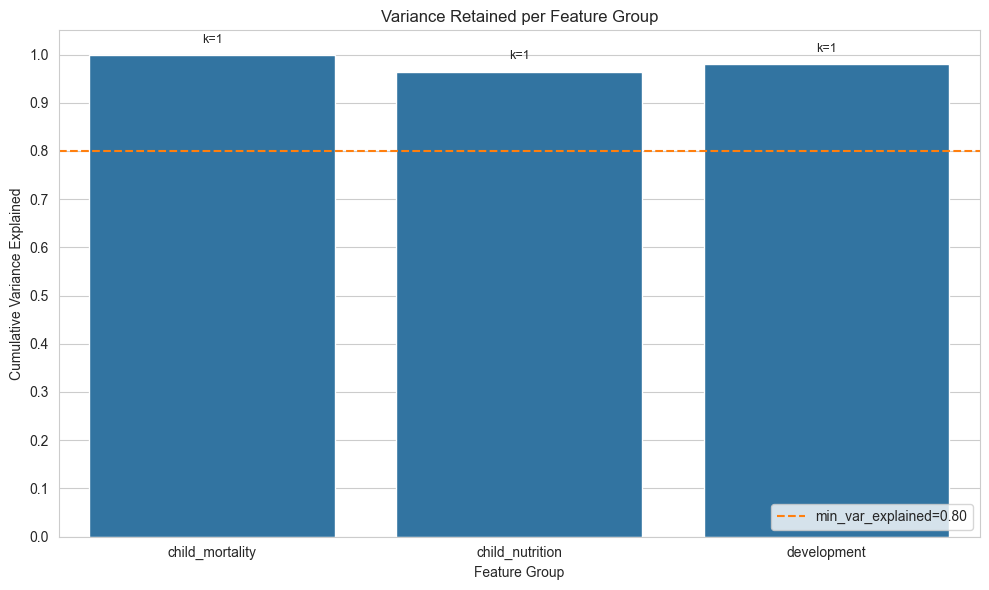

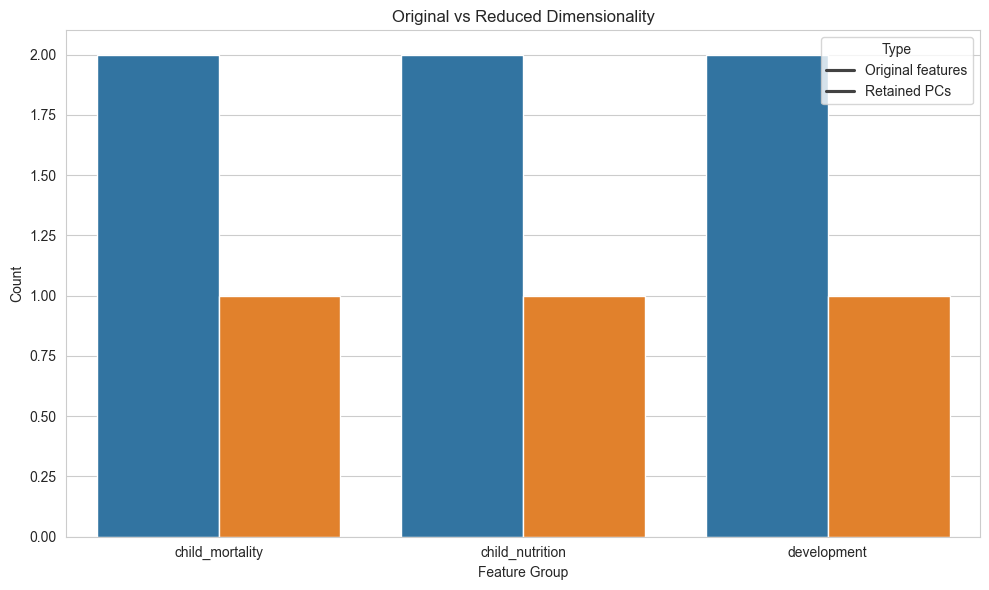

In [ ]:
fig1 = plot_group_variance_summary(result, figsize=(10, 6))
fig2 = plot_group_compression(result, figsize=(10, 6))
plt.show()


**Interpretation:**
- **Variance summary**: Shows cumulative variance explained by retained PCs per group
  - Groups above 0.8 threshold retain sufficient information
  - Annotation shows k = number of PCs retained
- **Compression plot**: Visualizes dimensionality reduction achieved
  - Blue bars = original features, orange bars = retained PCs
  - Larger gap indicates more aggressive compression

## 4. Feature Loadings

Shows how original features contribute to PC1 in each group.

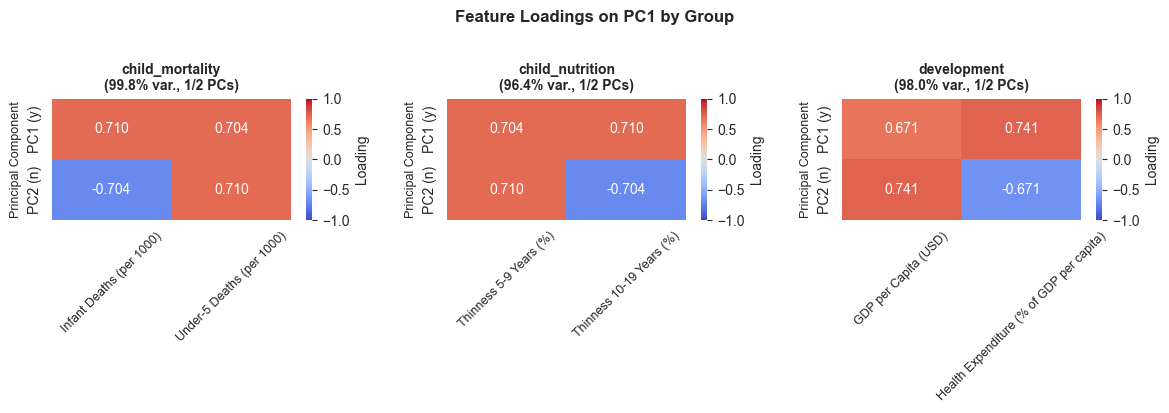

In [ ]:
fig = plot_group_loadings(result, figsize=(12, 4))
plt.show()


**Interpretation:**
- **Uniform loadings** (e.g., all ≈ 0.58): Features contribute equally → PC1 is essentially an average
- **Positive loadings**: All features increase together (common in correlated groups)
- **Magnitude**: Larger |loading| = stronger contribution to PC1
- PC1 = weighted sum of standardized original features using these loadings

## 5. Reduced Dataset & Target Correlations

Examine the reduced features and their relationship with life expectancy.

In [ ]:
print("Reduced Dataset Preview:")
print("=" * 80)
print(result.reduced_df.head())

# Add target and compute correlations
reduced_with_target = result.reduced_df.copy()
reduced_with_target[LECol.TARGET] = le_ds.df[LECol.TARGET]

print("\n\nCorrelation with Life Expectancy:")
print("=" * 80)
target_corr = (
    reduced_with_target.corr()[LECol.TARGET]
    .drop(LECol.TARGET)
    .sort_values(ascending=False)
)
for pc_name, corr_val in target_corr.items():
    print(f"{pc_name:30s}: r = {corr_val:7.3f}")


Reduced Dataset Preview:
   child_mortality_PC1  child_nutrition_PC1  development_PC1
0             0.347007             3.919150        -0.467921
1             0.372179             3.998580        -0.465749
2             0.397351             4.061943        -0.464966
3             0.432919             4.140920        -0.461321
4             0.462471             4.220350        -0.516299


Correlation with Life Expectancy:
development_PC1               : r =   0.428
child_mortality_PC1           : r =  -0.181
child_nutrition_PC1           : r =  -0.466


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_12521/1444422190.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


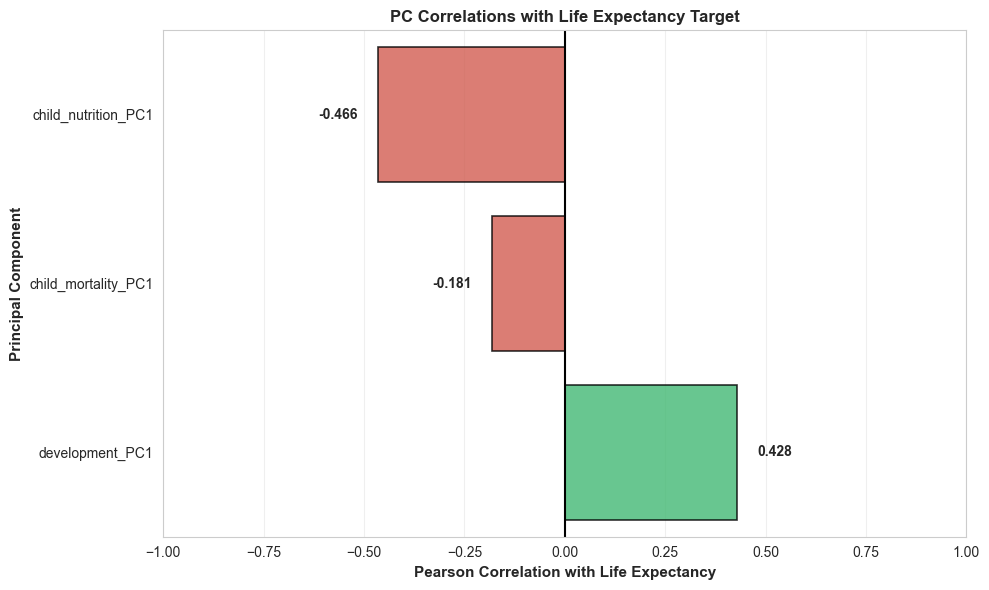

In [ ]:
# Visualize correlations with target using seaborn
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for seaborn
corr_df = pd.DataFrame(
    {"Principal Component": target_corr.index, "Correlation": target_corr.values}
).sort_values("Correlation", ascending=True)

# Create color palette
colors = ["#e74c3c" if x < 0 else "#2ecc71" for x in corr_df["Correlation"].values]

# Create horizontal barplot with seaborn
sns.barplot(
    data=corr_df,
    y="Principal Component",
    x="Correlation",
    palette=colors,
    ax=ax,
    edgecolor="black",
    linewidth=1.2,
    alpha=0.8,
)

ax.axvline(0, color="black", linewidth=1.5, linestyle="-")
ax.set_xlabel(
    "Pearson Correlation with Life Expectancy", fontsize=11, fontweight="bold"
)
ax.set_ylabel("Principal Component", fontsize=11, fontweight="bold")
ax.set_title(
    "PC Correlations with Life Expectancy Target", fontsize=12, fontweight="bold"
)
ax.set_xlim(-1, 1)
ax.grid(axis="x", alpha=0.3)

# Add value labels on bars
for i, row in corr_df.iterrows():
    corr_val = row["Correlation"]
    x_pos = corr_val + (0.05 if corr_val > 0 else -0.05)
    ha = "left" if corr_val > 0 else "right"
    y_pos = list(corr_df.index).index(i)
    ax.text(
        x_pos,
        y_pos,
        f"{corr_val:.3f}",
        va="center",
        ha=ha,
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()


**Interpretation:**
- **development_PC1** shows strongest positive correlation (r ≈ 0.76): Economic/educational development strongly predicts longer life expectancy
- **child_thinness_PC1** shows moderate negative correlation (r ≈ -0.47): Higher malnutrition rates associated with lower life expectancy
- **child_mortality_PC1** shows weak negative correlation (r ≈ -0.18): Death rates have smaller direct correlation with life expectancy in this reduced representation
- **development_PC2** (second component) captures residual variance not explained by PC1, with minimal target correlation

The PCA reduction successfully preserved the key predictive relationships while reducing dimensionality from 7 to 4 features.

**Interpretation:**
- **Points (colored by life expectancy)**: Each observation's position in PC space
  - Green points = higher life expectancy, Red points = lower life expectancy
  - Spread shows variability captured by these 2 PCs
- **Red arrows (loadings)**: Show how original features contribute to PCs
  - Arrow direction = feature's contribution to PC1 (x) and PC2 (y)
  - Arrow length = strength of contribution
  - Parallel arrows = features highly correlated with each other
  - Perpendicular arrows = features capture different aspects
- **Interpretation example**: If GDP and Schooling arrows point right → PC1 represents overall "development level"

### 6.4 Biplot: Development Group

Shows both observations (points) and feature loadings (arrows) in PC space. Helps understand what each PC represents and identify outlier observations.

**Interpretation:**
- **Left (Original)**: Shows strong correlations within feature groups (red/blue blocks)
  - High correlations (r > 0.8) indicate redundancy → good candidates for PCA reduction
- **Right (Reduced)**: PCs are nearly uncorrelated (diagonal pattern)
  - PCA creates **orthogonal** components by design (correlation ≈ 0)
  - Successfully removed multicollinearity while preserving information
- **Size reduction**: Fewer variables to model, reduced risk of overfitting

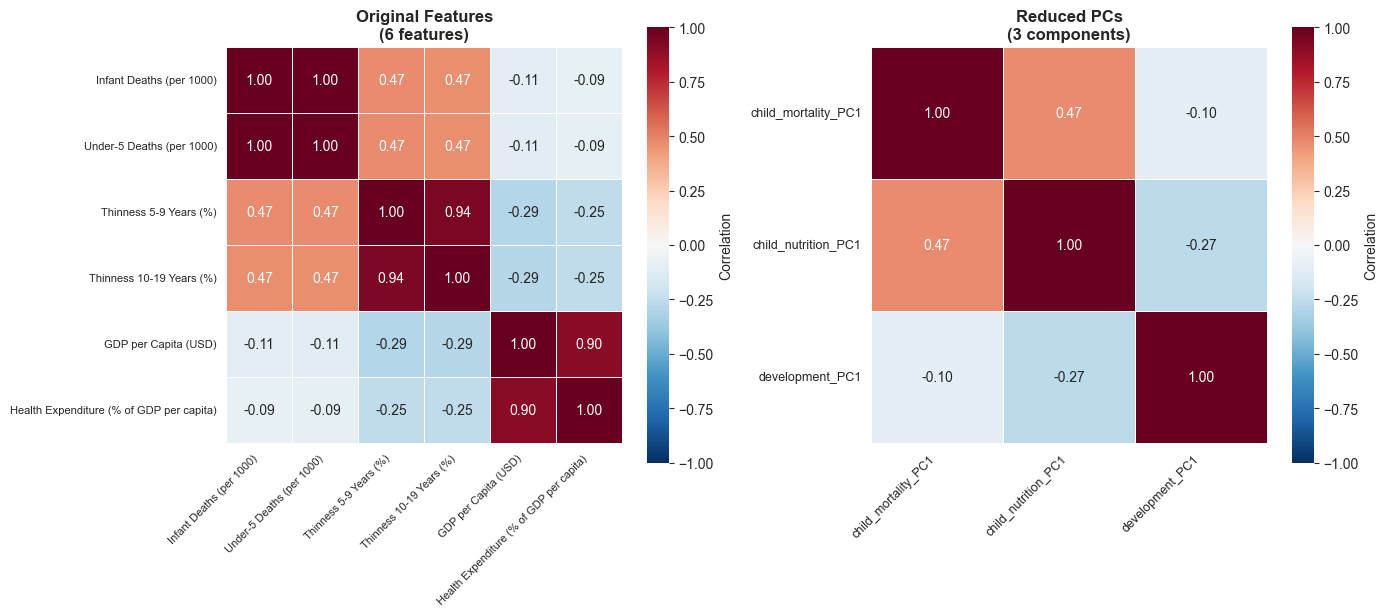

# dev - Original features: 6, Reduced PCs: 3


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get all original features used in groups
all_original_features = []
for gr in result.group_results:
    all_original_features.extend(gr.group.features)

# Original features correlation
original_corr = le_ds.df[all_original_features].corr()

# Plot original
sns.heatmap(
    original_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    ax=ax1,
)
ax1.set_title(
    f"Original Features\n({len(all_original_features)} features)", fontweight="bold"
)
ax1.set_xticklabels(
    [le_ds.get_pretty_name(f) for f in original_corr.columns],
    rotation=45,
    ha="right",
    fontsize=8,
)
ax1.set_yticklabels(
    [le_ds.get_pretty_name(f) for f in original_corr.columns], rotation=0, fontsize=8
)

# Reduced PCs correlation
reduced_corr = result.reduced_df.corr()

sns.heatmap(
    reduced_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    ax=ax2,
)
ax2.set_title(
    f"Reduced PCs\n({len(result.reduced_df.columns)} components)", fontweight="bold"
)
ax2.set_xticklabels(reduced_corr.columns, rotation=45, ha="right", fontsize=9)
ax2.set_yticklabels(reduced_corr.columns, rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

# dev - verify correlation comparison
print(
    f"# dev - Original features: {len(all_original_features)}, Reduced PCs: {len(result.reduced_df.columns)}"
)


### 6.3 Correlation Heatmap: Before vs After Reduction

Compare correlation structure of original features vs reduced PCs to visualize dimensionality reduction impact.

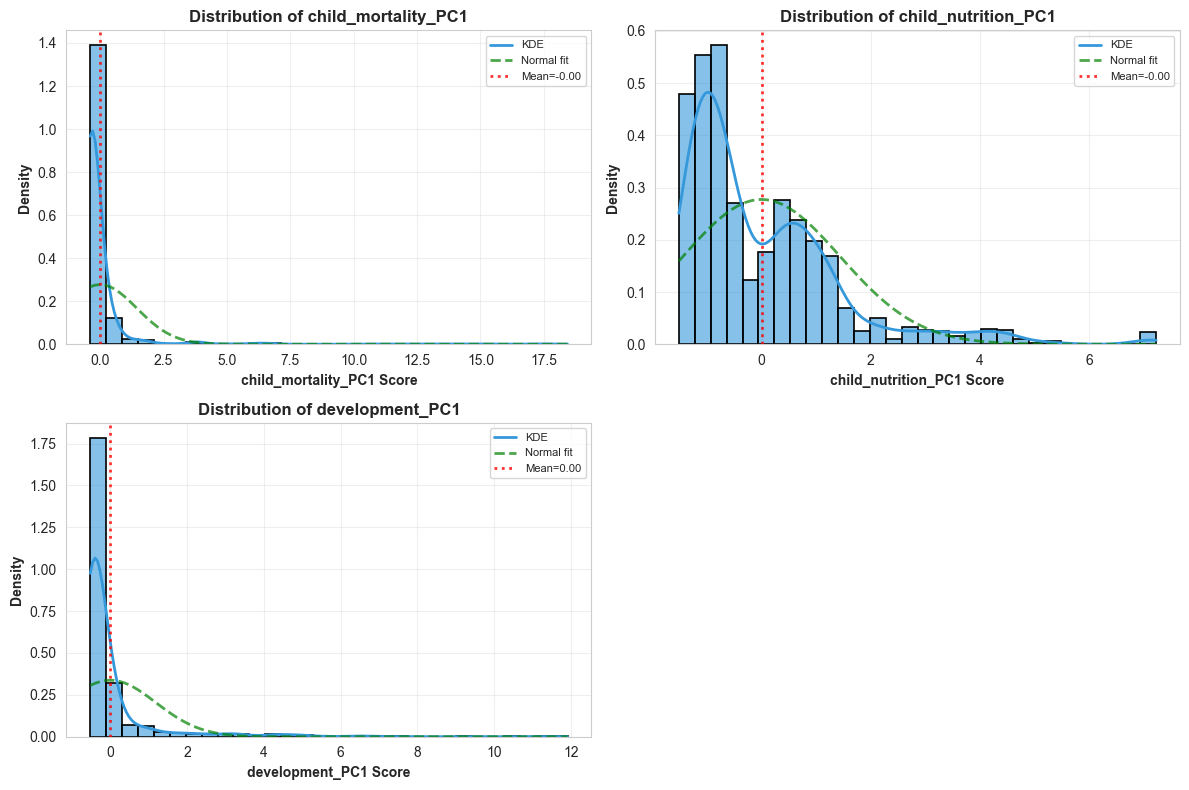

In [ ]:
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot distribution for each retained PC using seaborn
pc_cols = result.reduced_df.columns
for idx, pc_col in enumerate(pc_cols):
    if idx >= len(axes):
        break

    ax = axes[idx]
    data = result.reduced_df[pc_col]

    # Histogram with KDE using seaborn
    sns.histplot(
        data=data,
        bins=30,
        kde=True,
        color="#3498db",
        edgecolor="black",
        linewidth=1.2,
        stat="density",
        alpha=0.6,
        ax=ax,
        line_kws={"linewidth": 2, "color": "red", "label": "KDE"},
    )

    mu, sigma = data.mean(), data.std()
    x_range = np.linspace(data.min(), data.max(), 100)
    normal_curve = stats.norm.pdf(x_range, mu, sigma)
    ax.plot(x_range, normal_curve, "g--", linewidth=2, alpha=0.7, label="Normal fit")

    # Add mean line
    ax.axvline(
        mu, color="red", linestyle=":", linewidth=2, alpha=0.8, label=f"Mean={mu:.2f}"
    )

    ax.set_xlabel(f"{pc_col} Score", fontweight="bold")
    ax.set_ylabel("Density", fontweight="bold")
    ax.set_title(f"Distribution of {pc_col}", fontweight="bold")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(pc_cols), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


### 6.2 PC Score Distributions

Histograms showing how observations are distributed along each principal component. Should be approximately normal if data is well-behaved.

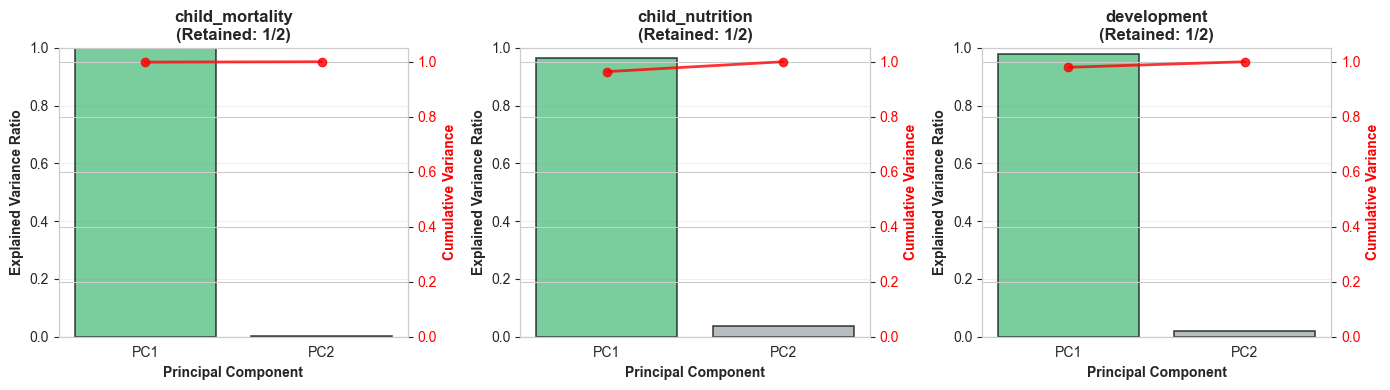

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, gr in enumerate(result.group_results):
    ax = axes[idx]

    # Prepare data for seaborn
    exp_var = gr.explained_variance["explained_ratio"].values
    n_pcs = len(exp_var)
    pc_labels = [f"PC{i + 1}" for i in range(n_pcs)]

    # Create DataFrame for seaborn
    scree_df = pd.DataFrame(
        {
            "PC": pc_labels,
            "Explained Variance": exp_var,
            "Retained": [
                "Retained" if i < gr.n_components else "Dropped" for i in range(n_pcs)
            ],
        }
    )

    # Create barplot with seaborn
    sns.barplot(
        data=scree_df,
        x="PC",
        y="Explained Variance",
        hue="Retained",
        palette={"Retained": "#2ecc71", "Dropped": "#95a5a6"},
        ax=ax,
        edgecolor="black",
        linewidth=1.2,
        alpha=0.7,
        legend=False,
    )

    ax.set_xlabel("Principal Component", fontweight="bold")
    ax.set_ylabel("Explained Variance Ratio", fontweight="bold")
    ax.set_title(
        f"{gr.group.name}\n(Retained: {gr.n_components}/{n_pcs})", fontweight="bold"
    )
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)

    # Add cumulative line
    ax2 = ax.twinx()
    cumulative = gr.explained_variance["cumulative_ratio"].values
    ax2.plot(range(n_pcs), cumulative, "ro-", linewidth=2, markersize=6, alpha=0.8)
    ax2.set_ylabel("Cumulative Variance", fontweight="bold", color="red")
    ax2.set_ylim(0, 1.05)
    ax2.tick_params(axis="y", labelcolor="red")

plt.tight_layout()
plt.show()


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

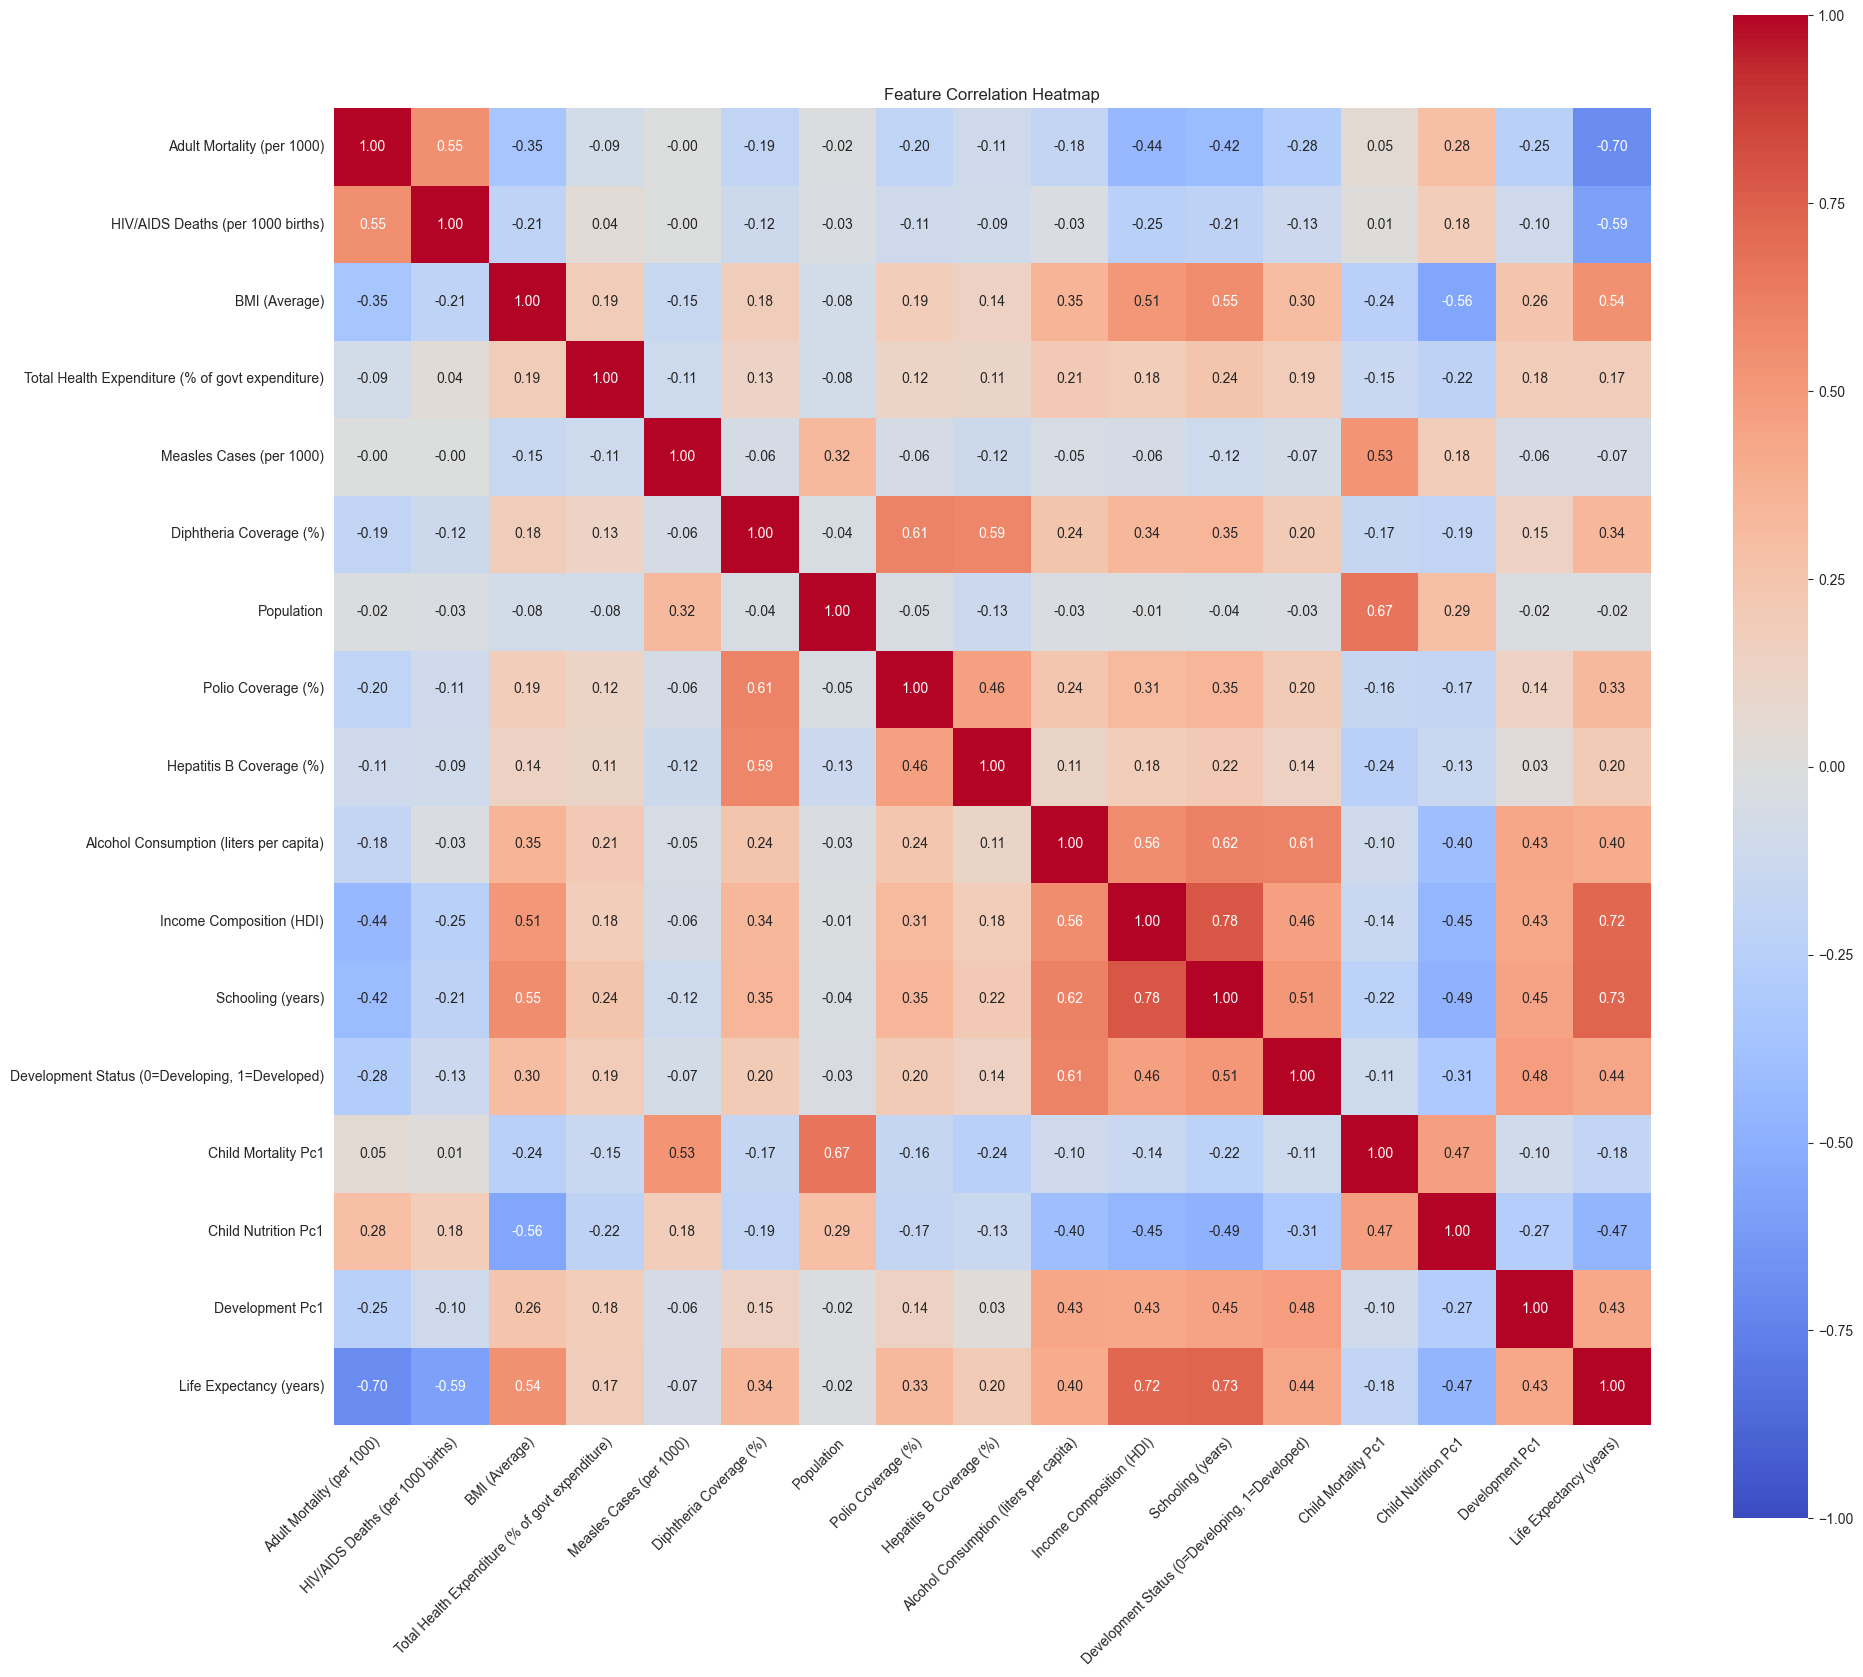

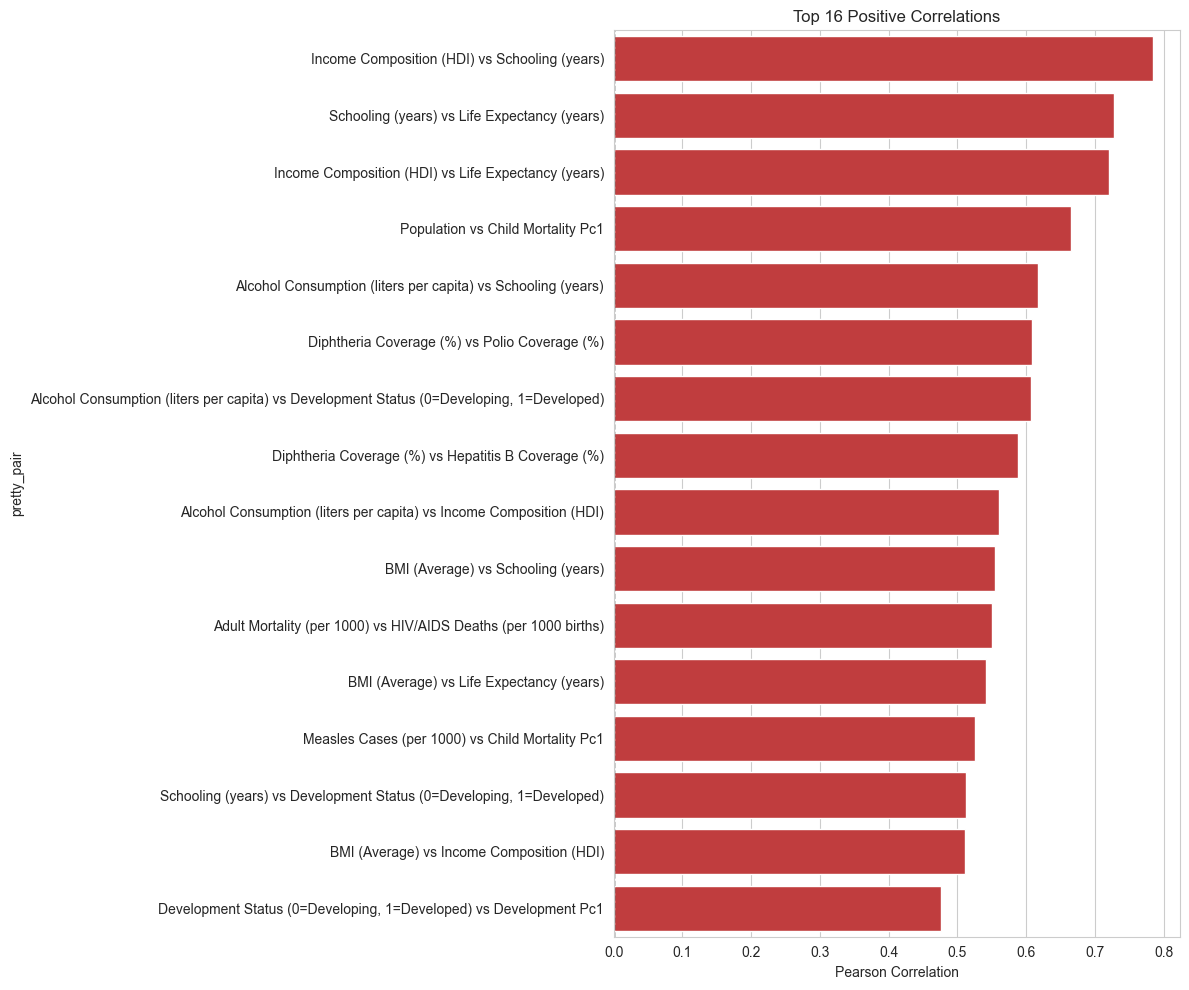

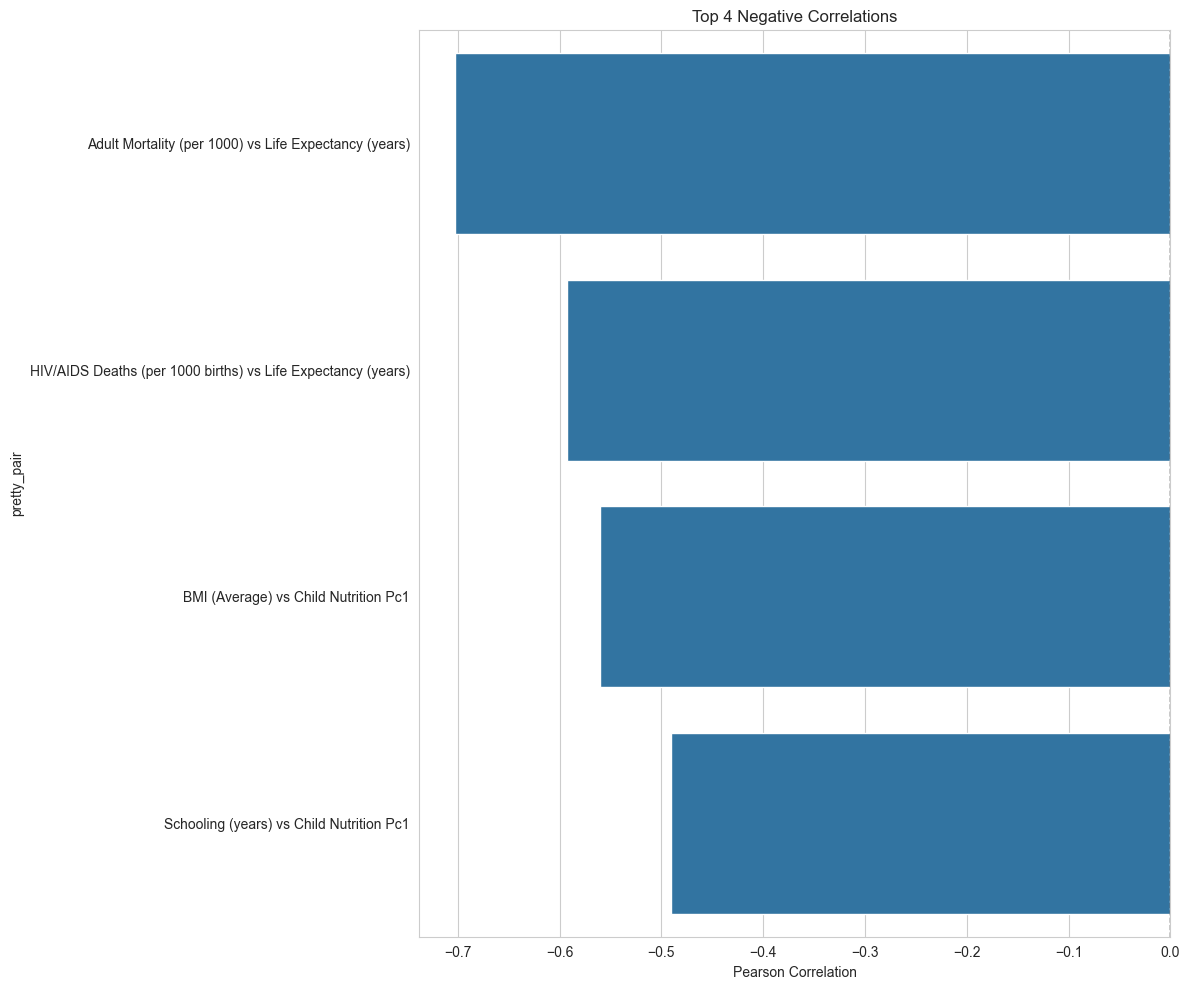

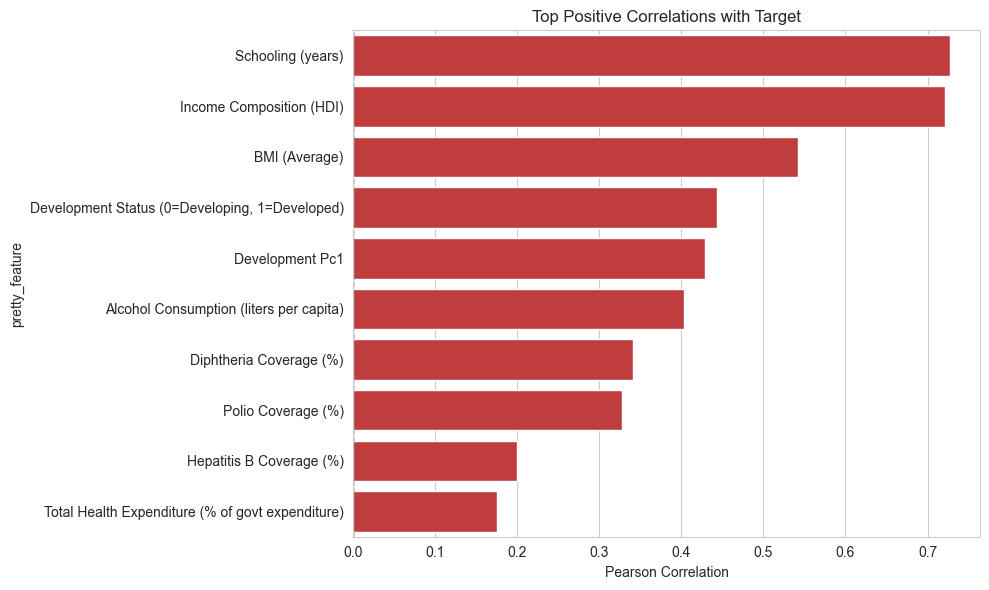

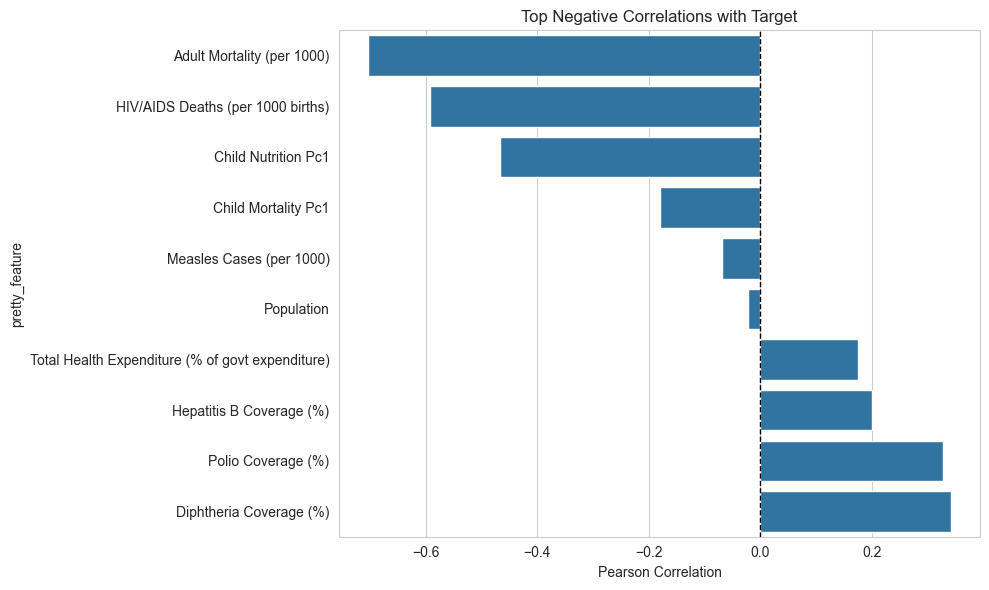

In [ ]:
from ama_tlbx.plotting import (
    plot_correlation_heatmap,
    plot_target_correlations,
    plot_top_correlated_pairs,
)

grouped_features = set()
for gr in result.group_results:
    grouped_features.update(gr.group.features)

# Get unaffected features (numeric features not in any group)
all_numeric = set(le_ds.numeric_cols)
unaffected_features = list(all_numeric - grouped_features - {LECol.TARGET})

corr_result = (
    LifeExpectancyDataset(
        df=(
            le_ds.df[unaffected_features]
            .join(result.reduced_df)
            .join(le_ds.df[[LECol.TARGET]])
        )
    )
    .make_correlation_analyzer()
    .fit()
    .result()
)

plot_correlation_heatmap(corr_result)
plot_top_correlated_pairs(corr_result, threshold=None)
plot_target_correlations(corr_result)
